In [102]:
using DataFrames
using CSV
using JSON
using HTTP
using Dates
using Gadfly
import Cairo, Fontconfig

In [103]:
ENV["COLUMNS"] = 1000;

In [104]:
function reinterpret1d(input)
    return Float64.(input)
end

function reinterpret2d(input)
    n, m = length(input), length(input[1])
    arr = Array{Float64,2}(undef, n, m)
    for i in 1:n
        arr[i,:] = Float64.(input[i])
    end
    return arr
end;

function reinterpret3d(input)
    n, m, l = length(input), length(input[1]), length(input[1][1])
    arr = Array{Float64,3}(undef, n, m, l)
    for i in 1:n, j in 1:m
        arr[i,j,:] = Float64.(input[i][j])
    end
    return arr
end;

In [105]:
request_data = Dict(
    :alloclevel => "hospital",
    :region_type => "state",
    :region_id => "MD",
    :hospitals => String[],
    :scenario => "moderate",
    :patient_type => "icu",
    :objective => "minoverflow",
    :integer => "false",
    :transferbudget => "1000",
    :utilization => "1.0",
    :covid_capacity_proportion => "0.5",
    :dist_threshold => "600",
    :uncertaintylevel => "default",
    :los => "default_dist",
    :start_date => "2020-12-15",
    :end_date => "2021-01-15",
    :smoothness => "false",
    :verbose => "true",
);

In [106]:
url = "https://covid-hospital-operations.com/api/patients";
# url = "http://localhost:8001/api/patients";

In [107]:
r_time = @elapsed r = HTTP.request("POST", url, ["Content-Type" => "application/json"], JSON.json(request_data))
response = String(r.body)
rawdata = JSON.parse(response)
println("Response time: $(r_time)")

Response time: 6.341155376


In [108]:
data = (
    region = rawdata["config"]["region"]["region_name"],
    start_date = Date(rawdata["config"]["start_date"]),
    end_date = Date(rawdata["config"]["end_date"]),
    hospital_names = string.(rawdata["config"]["node_names"]),
    hospital_ids = [h["hospital_id"] for h in rawdata["config"]["nodes_meta"]],
    admitted = reinterpret2d(rawdata["admitted"]),
    capacity = reinterpret1d(rawdata["beds"]),
    active = reinterpret2d(rawdata["active"]),
    active_null = reinterpret2d(rawdata["active_null"]),
    sent = reinterpret3d(rawdata["sent"]),
    total_patients = rawdata["total_patients"],
);

In [109]:
rnd(x) = round(x, digits=2);
pct(x) = string(round(x*100, digits=2)) * "%";

In [110]:
println("Region: ", data.region)
println("Number of hospitals: ", length(data.hospital_names))
println("Number of days: ", size(data.admitted, 2))
println("Date range: ", data.start_date, " to ", data.end_date)
println("Server response time: ", rnd(r_time), "s")
println("Number of transfers: ", rnd(sum(data.sent)))
println("Total patients: ", rnd(data.total_patients))
println("Percent of patients transferred: ", pct(sum(data.sent)/data.total_patients))
println("Total capacity: ", rnd(sum(data.capacity)))
println("Max system occupancy: ", rnd(maximum(sum(data.active_null, dims=1))))
println("Number of hospitals with overflow (no transfers): ", count(maximum(data.active_null, dims=2) - data.capacity .> 1e-5))
println("Number of hospitals with overflow (with transfers): ", count(maximum(data.active, dims=2) - data.capacity .> 1e-5))
println("Overflow (no transfers): ", rnd(sum(max.(data.active_null .- data.capacity, 0))))
println("Overflow (with transfers): ", rnd(sum(max.(data.active .- data.capacity, 0))))
println("Beds required (no transfers): ", rnd(sum(max.(maximum(data.active_null, dims=2) - data.capacity, 0))))
println("Beds required (with transfers): ", rnd(sum(max.(maximum(data.active, dims=2) - data.capacity, 0))))

Region: Maryland
Number of hospitals: 44
Number of days: 32
Date range: 2020-12-15 to 2021-01-15
Server response time: 6.34s
Number of transfers: 388.18
Total patients: 2572.22
Percent of patients transferred: 15.09%
Total capacity: 635.0
Max system occupancy: 450.9
Number of hospitals with overflow (no transfers): 26
Number of hospitals with overflow (with transfers): 11
Overflow (no transfers): 1803.13
Overflow (with transfers): 47.08
Beds required (no transfers): 117.35
Beds required (with transfers): 31.99


In [111]:
metrics_summary = DataFrame([
    ("Region", data.region),
    ("Number of hospitals", length(data.hospital_names)),
    ("Number of days", size(data.admitted, 2)),
    ("Start date", data.start_date),
    ("End date", data.end_date),
    ("Number of transfers", rnd(sum(data.sent))),
    ("Total patients", rnd(data.total_patients)),
    ("Percent of patients transferred", pct(sum(data.sent)/data.total_patients)),
    ("Total capacity", rnd(sum(data.capacity))),
    ("Max system occupancy", rnd(maximum(sum(data.active_null, dims=1)))),
    ("Number of hospitals with overflow (no transfers)", count(maximum(data.active_null, dims=2) - data.capacity .> 1e-5)),
    ("Number of hospitals with overflow (with transfers)", count(maximum(data.active, dims=2) - data.capacity .> 1e-5)),
    ("Overflow (no transfers)", rnd(sum(max.(data.active_null .- data.capacity, 0)))),
    ("Overflow (with transfers)", rnd(sum(max.(data.active .- data.capacity, 0)))),
    ("Beds required (no transfers)", rnd(sum(max.(maximum(data.active_null, dims=2) - data.capacity, 0)))),
    ("Beds required (with transfers)", rnd(sum(max.(maximum(data.active, dims=2) - data.capacity, 0)))),
])
rename!(metrics_summary, :1 => "Metric", :2 => "Value")

,Metric,Value
,String,Any
1,Region,Maryland
2,Number of hospitals,44
3,Number of days,32
4,Start date,2020-12-15
5,End date,2021-01-15
6,Number of transfers,388.18
7,Total patients,2572.22
8,Percent of patients transferred,15.09%
9,Total capacity,635.0


In [112]:
metadata = DataFrame(CSV.File("../data/hhs_hospital_meta.csv"));

In [113]:
hid_to_system = Dict(row.hospital_id => row.system_name for row in eachrow(metadata));
hid_to_city = Dict(row.hospital_id => row.city for row in eachrow(metadata));
hid_to_hrr = Dict(row.hospital_id => row.hrr_name for row in eachrow(metadata));
hid_to_hsa = Dict(row.hospital_id => row.hsa_name for row in eachrow(metadata));

In [114]:
metrics_byhospital = DataFrame([
    (
        hospital_name = data.hospital_names[i],
        hospital_id = data.hospital_ids[i],
        system_name = hid_to_system[data.hospital_ids[i]],
        city = hid_to_city[data.hospital_ids[i]],
        hrr = hid_to_hrr[data.hospital_ids[i]],
        hsa = hid_to_hsa[data.hospital_ids[i]],
        capacity = data.capacity[i],
        admissions = sum(data.admitted[i,:]),
        transfers_out = sum(data.sent[i,:,:]),
        transfers_in = sum(data.sent[:,i,:]),
        overflow_wtfr = round(sum(max.(data.active[i,:] .- data.capacity[i], 0)), digits=3),
        overflow_notfr = round(sum(max.(data.active_null[i,:] .- data.capacity[i], 0)), digits=3),
        maxload_wtfr = maximum(data.active[i,:] ./ data.capacity[i]),
        maxload_notfr = maximum(data.active_null[i,:] ./ data.capacity[i]),
        requiredbeds_wtfr = round(maximum(max.(data.active[i,:] .- data.capacity[i], 0)), digits=3),
        requiredbeds_notfr = round(maximum(max.(data.active_null[i,:] .- data.capacity[i], 0)), digits=3),
    )
    for i in 1:length(data.hospital_ids)
])

,hospital_name,hospital_id,system_name,city,hrr,hsa,capacity,admissions,transfers_out,transfers_in,overflow_wtfr,overflow_notfr,maxload_wtfr,maxload_notfr,requiredbeds_wtfr,requiredbeds_notfr
,String,String,String?,String,String,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Adventist Healthcare Fort Washington Medical Center,210060,missing,Fort Washington,"Washington, DC","Washington, DC",8.0,13.2918,0.0,28.1545,0.0,0.0,1.0,0.406378,0.0,0.0
2,Adventist Healthcare Shady Grove Medical Center,210057,Adventist Healthcare,Rockville,"Washington, DC","Rockville, MD",13.0,48.1224,0.0,14.8267,0.0,0.0,1.0,0.819152,0.0,0.0
3,Adventist Healthcare White Oak Medical Center,210016,Adventist Healthcare,Silver Spring,"Takoma Park, MD","Silver Spring, MD",14.0,64.4694,0.0,11.4448,0.0,0.0,1.0,0.978239,0.0,0.0
4,Anne Arundel Medical Center,210023,Anne Arundel Health System,Annapolis,"Washington, DC","Annapolis, MD",15.5,138.373,49.8724,0.0,0.0,222.49,1.0,1.69563,0.0,10.782
5,Atlantic General Hospital,210061,Atlantic General Health System,Berlin,"Salisbury, MD","Salisbury, MD",4.0,22.3408,3.21269,0.0,0.0,13.661,1.0,1.21344,0.0,0.854
6,Baltimore Convention Center Alternate Care Site,210068,missing,Baltimore,"Baltimore, MD","Baltimore, MD",0.0,75.6673,75.6673,0.0,0.0,344.829,NaN,Inf,0.0,14.797
7,CalvertHealth Medical Center,210039,Calvert Health System,Prince Frederick,"Washington, DC","Prince Frederick, MD",3.0,27.9857,12.9395,0.0,0.0,57.577,1.0,2.16357,0.0,3.491
8,Carroll Hospital Center,210033,LifeBridge Health,Westminster,"Baltimore, MD","Westminster, MD",5.5,49.3531,23.1186,0.0,0.276,109.392,1.05009,1.95153,0.276,5.233
9,Doctors Community Hospital,210051,missing,Lanham,"Takoma Park, MD","Lanham, MD",18.0,38.4429,0.0,33.7289,0.0,0.0,1.0,0.695125,0.0,0.0


In [115]:
metrics_bysystem = combine(groupby(metrics_byhospital, :system_name),
    :system_name => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_bysystem[ismissing.(metrics_bysystem.system_name), :system_name] .= "Unknown"
sort!(metrics_bysystem, :capacity, rev=true)

,system_name,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String?,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,University of Maryland Medical System,10,164.0,348.003,45.4205,137.5,3.663,198.917,3.663,14.159
2,MedStar Health,7,137.0,425.571,50.2932,30.0808,1.071,255.926,1.071,12.222
3,Johns Hopkins Health System,4,71.5,191.29,0.0,42.6651,0.0,0.0,0.0,0.0
4,Peninsula Regional Health System,1,42.5,99.0122,0.0,18.0115,0.0,0.0,0.0,0.0
5,Trinity Health,2,38.0,149.547,9.57773,9.06939,9.253,40.3,7.867,12.364
6,Unknown,4,28.0,141.487,80.3859,61.8833,0.204,369.788,0.204,15.886
7,Adventist Healthcare,2,27.0,112.592,0.0,26.2715,0.0,0.0,0.0,0.0
8,LifeBridge Health,3,25.0,201.539,64.8264,0.0,1.735,300.776,1.735,15.158
9,Anne Arundel Health System,1,15.5,138.373,49.8724,0.0,0.0,222.49,0.0,10.782


In [116]:
metrics_bycity = combine(groupby(metrics_byhospital, :city),
    :city => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_bycity[ismissing.(metrics_bycity.city), :city] .= "Unknown"
sort!(metrics_bycity, :capacity, rev=true)

,city,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,Baltimore,14,199.0,704.288,159.612,77.8566,14.072,766.803,10.122,42.109
2,Chestertown,1,102.5,46.9531,0.0,111.632,0.0,0.0,0.0,0.0
3,Silver Spring,2,44.5,174.796,8.33242,20.5142,9.253,37.325,7.867,11.559
4,Salisbury,1,42.5,99.0122,0.0,18.0115,0.0,0.0,0.0,0.0
5,La Plata,1,19.5,115.916,22.8569,0.0,0.949,104.889,0.949,4.448
6,Lanham,1,18.0,38.4429,0.0,33.7289,0.0,0.0,0.0,0.0
7,Bethesda,1,17.5,37.8245,0.0,15.8743,0.0,0.0,0.0,0.0
8,Annapolis,1,15.5,138.373,49.8724,0.0,0.0,222.49,0.0,10.782
9,Columbia,1,15.0,52.4633,0.0,5.00162,0.0,0.0,0.0,0.0


In [117]:
metrics_byhrr = combine(groupby(metrics_byhospital, :hrr),
    :hrr => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_byhrr[ismissing.(metrics_byhrr.hrr), :hrr] .= "Unknown"
sort!(metrics_byhrr, :capacity, rev=true)

,hrr,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"Baltimore, MD",23,359.0,1056.21,213.929,214.896,14.348,1005.04,10.398,56.514
2,"Washington, DC",12,135.5,662.816,144.067,90.6036,2.929,643.318,2.929,34.155
3,"Takoma Park, MD",5,77.5,274.084,12.0376,62.6775,9.508,54.195,8.122,12.861
4,"Salisbury, MD",2,46.5,121.353,3.21269,18.0115,0.0,13.661,0.0,0.854
5,"Wilmington, DE",1,14.5,61.1571,10.2118,1.98779,20.088,61.95,10.337,11.88
6,"Morgantown, WV",1,2.0,14.0851,4.7186,0.0,0.204,24.959,0.204,1.089


In [118]:
metrics_byhsa = combine(groupby(metrics_byhospital, :hsa),
    :hsa => length => :number_of_hospitals,
    :capacity => sum => :capacity,
    :admissions => sum => :admissions,
    :transfers_out => sum => :transfers_out,
    :transfers_in => sum => :transfers_in,
    :overflow_wtfr => sum => :overflow_with_transfers,
    :overflow_notfr => sum => :overflow_without_transfers,
    :requiredbeds_wtfr => sum => :required_beds_with_transfers,
    :requiredbeds_notfr => sum => :required_beds_without_transfers,
)
metrics_byhsa[ismissing.(metrics_byhsa.hsa), :hsa] .= "Unknown"
sort!(metrics_byhsa, :capacity, rev=true)

,hsa,number_of_hospitals,capacity,admissions,transfers_out,transfers_in,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,String,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,"Baltimore, MD",15,206.5,713.618,159.612,97.4029,14.072,766.803,10.122,42.109
2,"Chestertown, MD",1,102.5,46.9531,0.0,111.632,0.0,0.0,0.0,0.0
3,"Salisbury, MD",2,46.5,121.353,3.21269,18.0115,0.0,13.661,0.0,0.854
4,"Silver Spring, MD",2,44.5,174.796,8.33242,20.5142,9.253,37.325,7.867,11.559
5,"Rockville, MD",2,20.5,87.3429,1.24532,14.8267,0.0,2.975,0.0,0.805
6,"La Plata, MD",1,19.5,115.916,22.8569,0.0,0.949,104.889,0.949,4.448
7,"Lanham, MD",1,18.0,38.4429,0.0,33.7289,0.0,0.0,0.0,0.0
8,"Bethesda, MD",1,17.5,37.8245,0.0,15.8743,0.0,0.0,0.0,0.0
9,"Annapolis, MD",1,15.5,138.373,49.8724,0.0,0.0,222.49,0.0,10.782


In [119]:
metrics_bydate = DataFrame([
    (
        date = data.start_date + Day(t-1),
        active_patients = sum(data.active_null[:,t]),
        admissions = sum(data.admitted[:,t]),
        transfers = sum(data.sent[:,:,t]),
        overflow_with_transfers = round(sum(max.(data.active[:,t] - data.capacity, 0)), digits=3),
        overflow_without_transfers = round(sum(max.(data.active_null[:,t] - data.capacity, 0)), digits=3),
        required_beds_with_transfers = round(maximum(max.(data.active[:,t] - data.capacity, 0)), digits=3),
        required_beds_without_transfers = round(maximum(max.(data.active_null[:,t] - data.capacity, 0)), digits=3),
    )
    for t in 1:size(data.active, 2)
])

,date,active_patients,admissions,transfers,overflow_with_transfers,overflow_without_transfers,required_beds_with_transfers,required_beds_without_transfers
,Date,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2020-12-15,450.896,68.386,28.9488,31.99,60.939,10.337,11.88
2,2020-12-16,439.486,69.0045,19.1877,10.357,51.663,6.141,8.956
3,2020-12-17,435.32,69.6229,11.8167,4.149,47.387,3.028,6.958
4,2020-12-18,434.212,70.2414,12.1927,0.582,46.155,0.582,6.265
5,2020-12-19,433.466,69.5864,10.1965,0.0,45.868,0.0,7.129
6,2020-12-20,432.716,68.9314,9.98603,0.0,46.443,0.0,7.772
7,2020-12-21,431.787,68.2764,10.7675,0.0,47.444,0.0,8.235
8,2020-12-22,430.611,67.6214,10.7227,0.0,47.921,0.0,8.55
9,2020-12-23,429.167,66.9664,10.6184,0.0,49.022,0.0,8.742


In [120]:
results_path = "./results_v1/"
if !isdir(results_path) mkdir(results_path); end

In [121]:
metrics_summary |> CSV.write(joinpath(results_path, "metrics_summary.csv"));
metrics_byhospital |> CSV.write(joinpath(results_path, "metrics_byhospital.csv"));
metrics_bysystem |> CSV.write(joinpath(results_path, "metrics_bysystem.csv"));
metrics_bycity |> CSV.write(joinpath(results_path, "metrics_bycity.csv"));
metrics_byhrr |> CSV.write(joinpath(results_path, "metrics_byhrr.csv"));
metrics_byhsa |> CSV.write(joinpath(results_path, "metrics_byhsa.csv"));
metrics_bydate |> CSV.write(joinpath(results_path, "metrics_bydate.csv"));

In [122]:
sumvals(xs) = sum(skipmissing(xs));

In [123]:
hhsdata = DataFrame(CSV.File("../data/hhs_data_2021_02_08.csv"))
filter!(row -> row.hospital_id ∈ data.hospital_ids, hhsdata)
hhstotal = combine(groupby(hhsdata, :date),
    :admissions_icu => sumvals => :admissions_icu,
    :active_icu => sumvals => :active_icu,
);

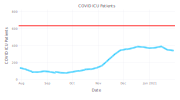

In [124]:
plt = plot(
    layer(
        hhstotal,
        x = :date,
        y = :active_icu,
        Geom.point, Geom.line,
    ),
    layer(
        yintercept = [sum(data.capacity)],
        Geom.hline(color="red", size=0.8mm),
    ),
    Scale.y_continuous(format=:plain),
    Guide.xlabel("Date"),
    Guide.ylabel("COVID ICU Patients"),
    Guide.title("COVID ICU Patients"),
    style(background_color=colorant"white"),
)
plt |> SVG(18cm, 10cm)
plt |> PDF(joinpath(results_path, "active_patients.pdf"), 18cm, 10cm)

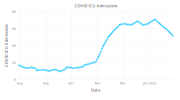

In [125]:
plt = plot(
    hhstotal,
    x = :date,
    y = :admissions_icu,
    Geom.point, Geom.line,
    Guide.xlabel("Date"),
    Guide.ylabel("COVID ICU Admissions"),
    Guide.title("COVID ICU Admissions"),
    style(background_color=colorant"white"),
)
plt |> SVG(18cm, 10cm)
plt |> PDF(joinpath(results_path, "admitted_patients.pdf"), 18cm, 10cm)